In [46]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import string

from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_style('whitegrid')

In [47]:
# data1 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
df = pd.read_csv('clean_data.csv')
df.head(10)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,1,inclement weather prevents liar from getting t...
3,1,mother comes pretty close to using word stream...
4,0,my white inheritance
5,1,richard bransons global warming donation nearl...
6,1,shadow government getting too large to meet in...
7,0,lots of parents know this scenario
8,0,this lesbian is considered a father in indiana...
9,0,amanda peet told her daughter sex is a special...


/tmp/ipykernel_13813/4276027927.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")


Text(0.5, 1.0, 'Countplot of headlines')

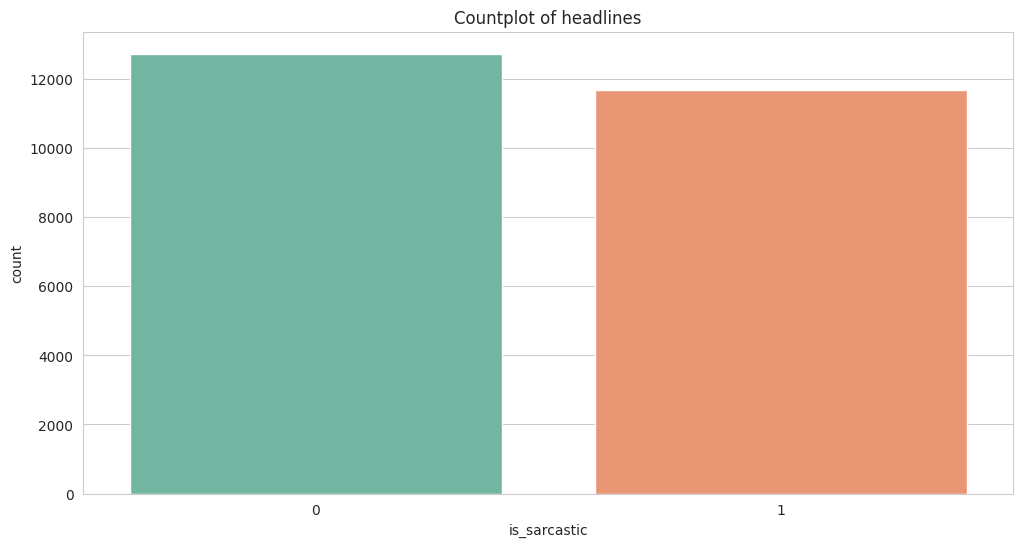

In [48]:
# Check number of headlines by is_sarcastics
plt.figure(figsize=(12,6))
sns.countplot(x = 'is_sarcastic', data = df, palette="Set2").set_title("Countplot of headlines")

In [49]:
# Add new column 'headline_len': Text length of headline 
df['headline_len'] = df['headline'].map(len)

In [50]:
# Sort dataframe by headline length. Check the longest headline.
df.sort_values(by='headline_len', ascending=False).head(4)

,is_sarcastic,headline,headline_len
6217,1,hot wheels ranked number one toy for rolling d...,911
22674,1,jared kushner claims that russian interference...,202
3966,1,roy moore on pedophilia accusers these women a...,187
23855,1,mia farrow its possible my son was fathered by...,186


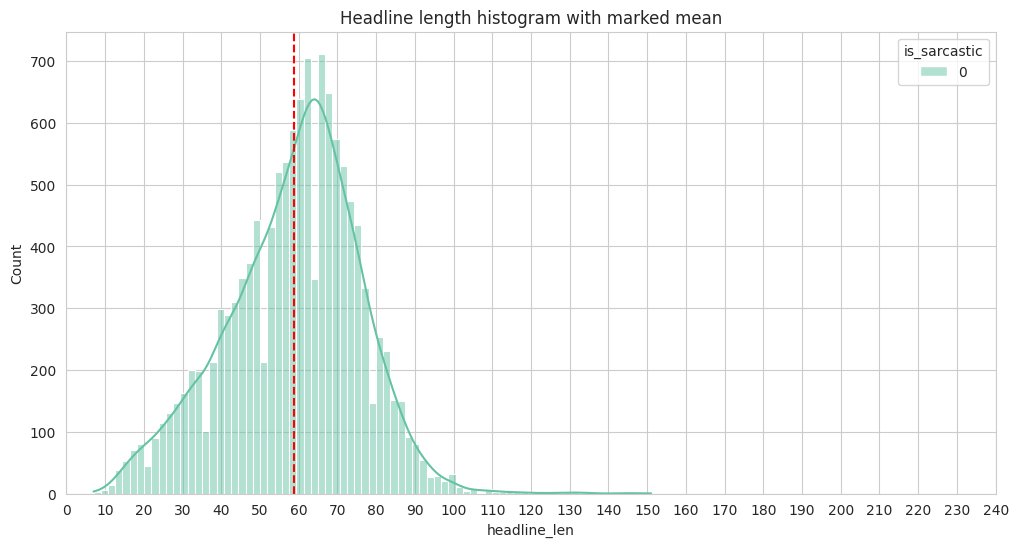

In [51]:
# Histogram of headline length for not "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)], 
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 0
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(), 
                color='r', linestyle = '--')

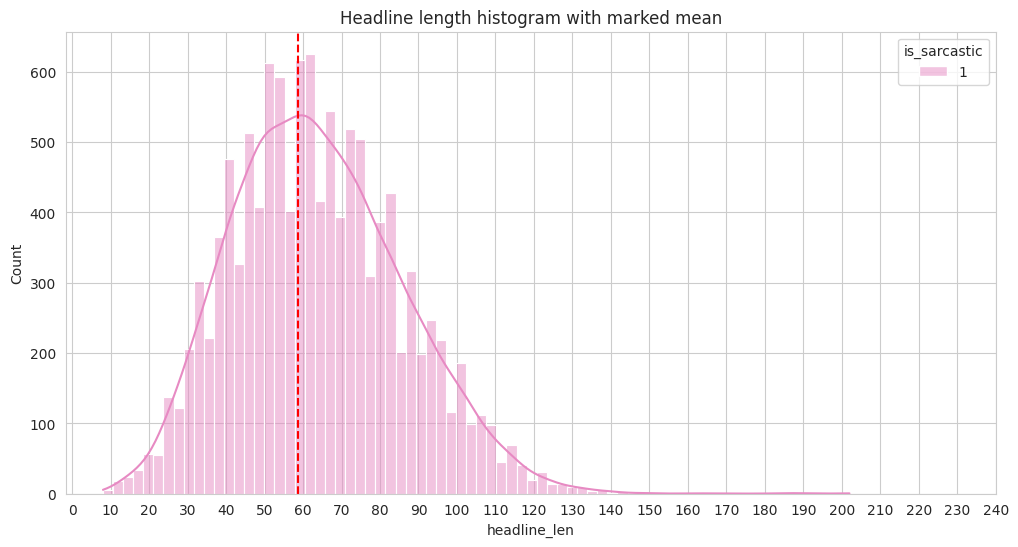

In [52]:
# Histogram of headline length for "is_sarcastic"
plt.figure(figsize=(12,6))

# Headline len limited to 250
g = sns.histplot(data = df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 1)], 
             x = 'headline_len', hue = 'is_sarcastic', kde = True, palette='Set2_r').set_title("Headline length histogram with marked mean")
# Set xticks
g = plt.xticks(np.arange(0, 250, 10))
# Show headline length mean for is_sarcastic = 1
g = plt.axvline(df[(df['headline_len'] < 250) & (df['is_sarcastic'] == 0)].headline_len.mean(), 
                color='r', linestyle = '--')

In [53]:
# List of stopwords
# stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [62]:
# sentences = []
# labels = []

# # append all headlines text and label (is_sarcastic) to list
# for ind, row in df.iterrows():
#   labels.append(row['is_sarcastic'])
#   sentence = row['headline']
#   # remove stopwords in sentences
#   for word in stopwords:
#       token = " " + word + " "
#       sentence = sentence.replace(token, " ")
#       sentence = sentence.replace("  ", " ")
#   sentences.append(sentence)

In [55]:
# def clean_sentences(sentences):
#     '''
#     Make text lowercase, remove text in square brackets, 
#     remove punctuation and remove words containing numbers.
#     '''
#     cln_sentences = []
#     for text in sentences:
#       text = text.lower()
#       text = re.sub('\[.*?\]', '', text)
#       text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#       text = re.sub('\w*\d\w*', '', text)
#       cln_sentences.append(text)
#     return cln_sentences

# sentences = clean_sentences(sentences)

In [60]:
# Set parameters
vocab_size = 10000    # Max len of unique words
embedding_dim = 200   # Embedding dimension value
max_length = 60       # Max length of sentence
padding_type = 'post' # pad_sequences arg
oov_tok = '<OOV>'     # Unknow words = <OOV>
# training_portion = .7 # train test split 70:30

In [63]:
from sklearn.model_selection import train_test_split
# Set the train size using training_portion arg
# train_size = int(len(sentences) * training_portion)

# Split
# train_sentences = sentences[:train_size]
# train_labels = labels[:train_size]

# validation_sentences = sentences[train_size:]
# validation_labels = labels[train_size:]
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(df['headline'], df['is_sarcastic'], test_size=0.3, random_state=42)

# Check
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

17090
17090
7325
7325


In [64]:
# Tokenizing and padding
# For Train
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length)

In [65]:
# Prepare labels for model: Train
training_labels_final = np.array(train_labels)
validation_labels_final = np.array(validation_labels)

# Check shapes
print(training_labels_final.shape)
print(validation_labels_final.shape)

(17090,)
(7325,)


In [66]:
# MODEL
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [67]:
# MODEL
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(40, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [68]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 200)           2000000   
                                                                 
 global_max_pooling1d_2 (Gl  (None, 200)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 40)                8040      
                                                                 
 dropout_8 (Dropout)         (None, 40)                0         
                                                                 
 dense_11 (Dense)            (None, 20)                820       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                      

In [69]:
# Set callback functions to early stop training and save the best model so far
filepath='best_model.h5'
overfitCallback = [EarlyStopping(monitor='val_loss', patience=5),
         ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)]

In [70]:
# Fit the model
num_epochs = 30
#history = model.fit(train_padded, training_labels_final, epochs=num_epochs, callbacks=[overfitCallback], validation_data=(validation_padded, validation_labels_final))
history = model.fit(train_padded, training_labels_final, epochs=num_epochs, validation_data=(validation_padded, validation_labels_final))

Epoch 1/30
535/535 [==============================] - 6s 9ms/step - loss: 0.6147 - accuracy: 0.6652 - val_loss: 0.4817 - val_accuracy: 0.8031
Epoch 2/30
535/535 [==============================] - 5s 9ms/step - loss: 0.4065 - accuracy: 0.8508 - val_loss: 0.4174 - val_accuracy: 0.8217
Epoch 3/30
535/535 [==============================] - 5s 8ms/step - loss: 0.2709 - accuracy: 0.9156 - val_loss: 0.4529 - val_accuracy: 0.8314
Epoch 4/30
535/535 [==============================] - 5s 9ms/step - loss: 0.1852 - accuracy: 0.9494 - val_loss: 0.5836 - val_accuracy: 0.8262
Epoch 5/30
535/535 [==============================] - 5s 8ms/step - loss: 0.1375 - accuracy: 0.9655 - val_loss: 1.0028 - val_accuracy: 0.8254
Epoch 6/30
535/535 [==============================] - 5s 8ms/step - loss: 0.1135 - accuracy: 0.9740 - val_loss: 1.2972 - val_accuracy: 0.8285
Epoch 7/30
535/535 [==============================] - 5s 9ms/step - loss: 0.1055 - accuracy: 0.9767 - val_loss: 1.2412 - val_accuracy: 0.8278
Epoch 

In [71]:
# evaluate the model
_, train_acc = model.evaluate(train_padded, training_labels_final)
_, test_acc = model.evaluate(validation_padded, validation_labels_final)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

  1/535 [..............................] - ETA: 11s - loss: 0.1307 - accuracy: 0.9688

229/229 [==============================] - 0s 2ms/step - loss: 4.2695 - accuracy: 0.8232
Train: 0.992, Test: 0.823


In [72]:
print(train_acc, test_acc)

0.9920421242713928 0.823208212852478


In [73]:
best = {
  "loss": history.history['loss'][27],
  "accuracy": history.history['accuracy'][27],
  "val_loss": history.history['val_loss'][27],
  "val_accuracy": history.history['val_accuracy'][27]
}

best

{'loss': 0.05173454061150551,
 'accuracy': 0.9889408946037292,
 'val_loss': 3.57983660697937,
 'val_accuracy': 0.8227986097335815}

In [74]:
# predict probabilities for test set
yhat_probs = model.predict(validation_padded, verbose=0)
#yhat_classes = model.predict_classes(validation_padded, verbose=0)

In [75]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(validation_labels_final, yhat_probs.round())
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(validation_labels_final, yhat_probs.round())
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(validation_labels_final, yhat_probs.round())
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(validation_labels_final, yhat_probs.round())
print('F1 score: %f' % f1)

Accuracy: 0.823208
Precision: 0.795046
Recall: 0.843488
F1 score: 0.818551


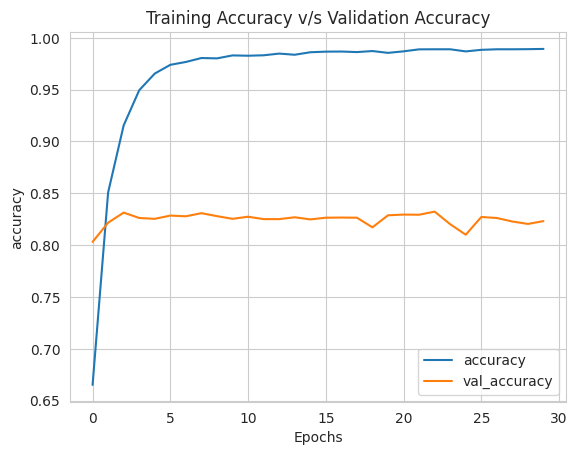

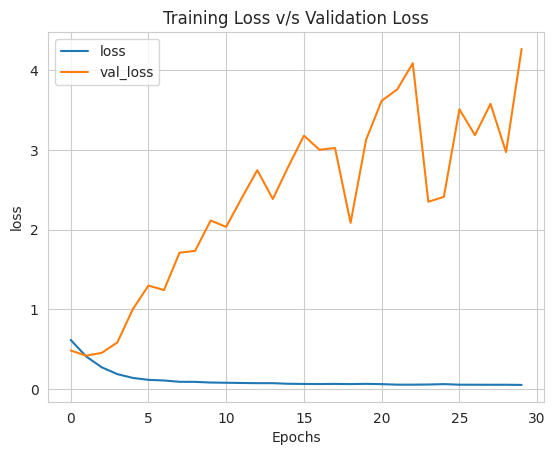

In [77]:
# Plot train and validation Accuracy and Loss
def plot_graphs(history, string, string2):
  plt.title(string)
  plt.plot(history.history[string2])
  plt.plot(history.history['val_'+string2])
  plt.xlabel("Epochs")
  plt.ylabel(string2)
  plt.legend([string2, 'val_'+string2])
  plt.show()

plot_graphs(history, "Training Accuracy v/s Validation Accuracy", "accuracy")
print("")
plot_graphs(history, "Training Loss v/s Validation Loss", "loss")

In [78]:
# Print Confusion matrix
print(classification_report(validation_labels, yhat_probs.round(), target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.85      0.81      0.83      3862
    Sarcastic       0.80      0.84      0.82      3463

     accuracy                           0.82      7325
    macro avg       0.82      0.82      0.82      7325
 weighted avg       0.82      0.82      0.82      7325



# others
we don't need to considered these models, but we can say that SVM is good.

In [79]:
datafile1 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
datafile2 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [80]:
datafile1=datafile1.drop(['article_link'],axis=1)
datafile2=datafile2.drop(['article_link'],axis=1)

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [82]:
x = datafile1.headline.values
y = datafile1.is_sarcastic.values

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.5)

In [83]:
Y_train.shape

(13354,)

In [84]:
type(x)

numpy.ndarray

In [85]:
BernNB = make_pipeline(TfidfVectorizer(), BernoulliNB())
BernNB.fit(X_train,Y_train)
Y_bexpect = Y_test
Y_bprid = BernNB.predict(X_test)

b_accuracy = accuracy_score(Y_test, Y_bprid)
print('Accuracy: %f' % b_accuracy)

b_precision = precision_score(Y_test, Y_bprid)
print('Precision: %f' % b_precision)

b_recall = recall_score(Y_test, Y_bprid)
print('Recall: %f' % b_recall)

b_f1 = f1_score(Y_test, Y_bprid)
print('F1 score: %f' % b_f1)

Accuracy: 0.830176
Precision: 0.865365
Recall: 0.728937
F1 score: 0.791314


In [86]:
MultiNB = make_pipeline(TfidfVectorizer(), MultinomialNB())
MultiNB.fit(X_train,Y_train)
Y_mexpect = Y_test
Y_mprid = MultiNB.predict(X_test)

m_accuracy = accuracy_score(Y_test, Y_mprid)
print('Accuracy: %f' % m_accuracy)

m_precision = precision_score(Y_test, Y_mprid)
print('Precision: %f' % m_precision)

m_recall = recall_score(Y_test, Y_mprid)
print('Recall: %f' % m_recall)

m_f1 = f1_score(Y_test, Y_mprid)
print('F1 score: %f' % m_f1)

Accuracy: 0.805092
Precision: 0.895204
Recall: 0.632819
F1 score: 0.741484


In [87]:
svm = make_pipeline(TfidfVectorizer(), SVC())
svm.fit(X_train,Y_train)
Y_sexpect = Y_test
Y_spred = svm.predict(X_test)

s_accuracy = accuracy_score(Y_test, Y_spred)
print('Accuracy: %f' % s_accuracy)

s_precision = precision_score(Y_test, Y_spred)
print('Precision: %f' % s_precision)

s_recall = recall_score(Y_test, Y_spred)
print('Recall: %f' % s_recall)

s_f1 = f1_score(Y_test, Y_spred)
print('F1 score: %f' % s_f1)

Accuracy: 0.839012
Precision: 0.818089
Recall: 0.817257
F1 score: 0.817673


In [88]:
Dtree = make_pipeline(TfidfVectorizer(), DecisionTreeClassifier())
Dtree.fit(X_train,Y_train)
Y_dexpect = Y_test
Y_dpred = Dtree.predict(X_test)

d_accuracy = accuracy_score(Y_test, Y_dpred)
print('Accuracy: %f' % d_accuracy)

d_precision = precision_score(Y_test, Y_dpred)
print('Precision: %f' % d_precision)

d_recall = recall_score(Y_test, Y_dpred)
print('Recall: %f' % d_recall)

d_f1 = f1_score(Y_test, Y_dpred)
print('F1 score: %f' % d_f1)

Accuracy: 0.735754
Precision: 0.699294
Recall: 0.704865
F1 score: 0.702068


In [89]:
RF = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
RF.fit(X_train, Y_train)
Y_rexpect = Y_test
Y_rpred = RF.predict(X_test)

r_accuracy = accuracy_score(Y_test, Y_rpred)
print('Accuracy: %f' % r_accuracy)

r_precision = precision_score(Y_test, Y_rpred)
print('Precision: %f' % r_precision)

r_recall = recall_score(Y_test, Y_rpred)
print('Recall: %f' % r_recall)

r_f1 = f1_score(Y_test, Y_rpred)
print('F1 score: %f' % r_f1)

Accuracy: 0.804418
Precision: 0.777759
Recall: 0.780132
F1 score: 0.778944


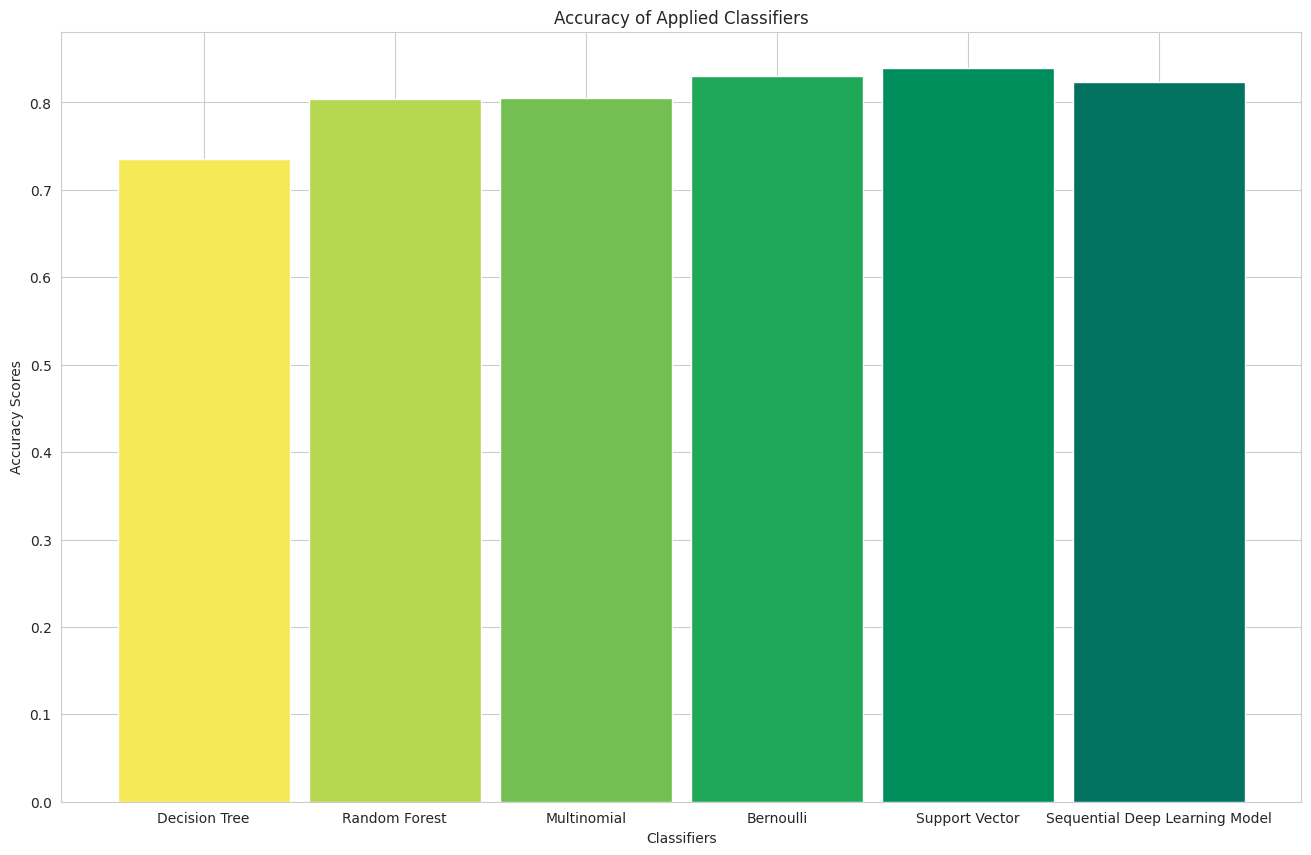

In [90]:
# x-coordinates of left sides of bars
left = [1, 2, 3, 4, 5, 6]
 
plt.figure(figsize=(16,10))
# heights of bars
height = [d_accuracy, r_accuracy, m_accuracy, b_accuracy, s_accuracy, accuracy]
 
# labels for bars
tick_label = ['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model']
 
# plotting a bar chart
plt.bar(left, height, tick_label = tick_label,
        width = 0.9, color = ['#f6e958', '#b4d650', '#73bf51', '#20a757', '#008d5c', '#00725f'])
 
# naming the x-axis
plt.xlabel('Classifiers')
# naming the y-axis
plt.ylabel('Accuracy Scores')
# plot title
plt.title('Accuracy of Applied Classifiers')
 
# function to show the plot
plt.show()

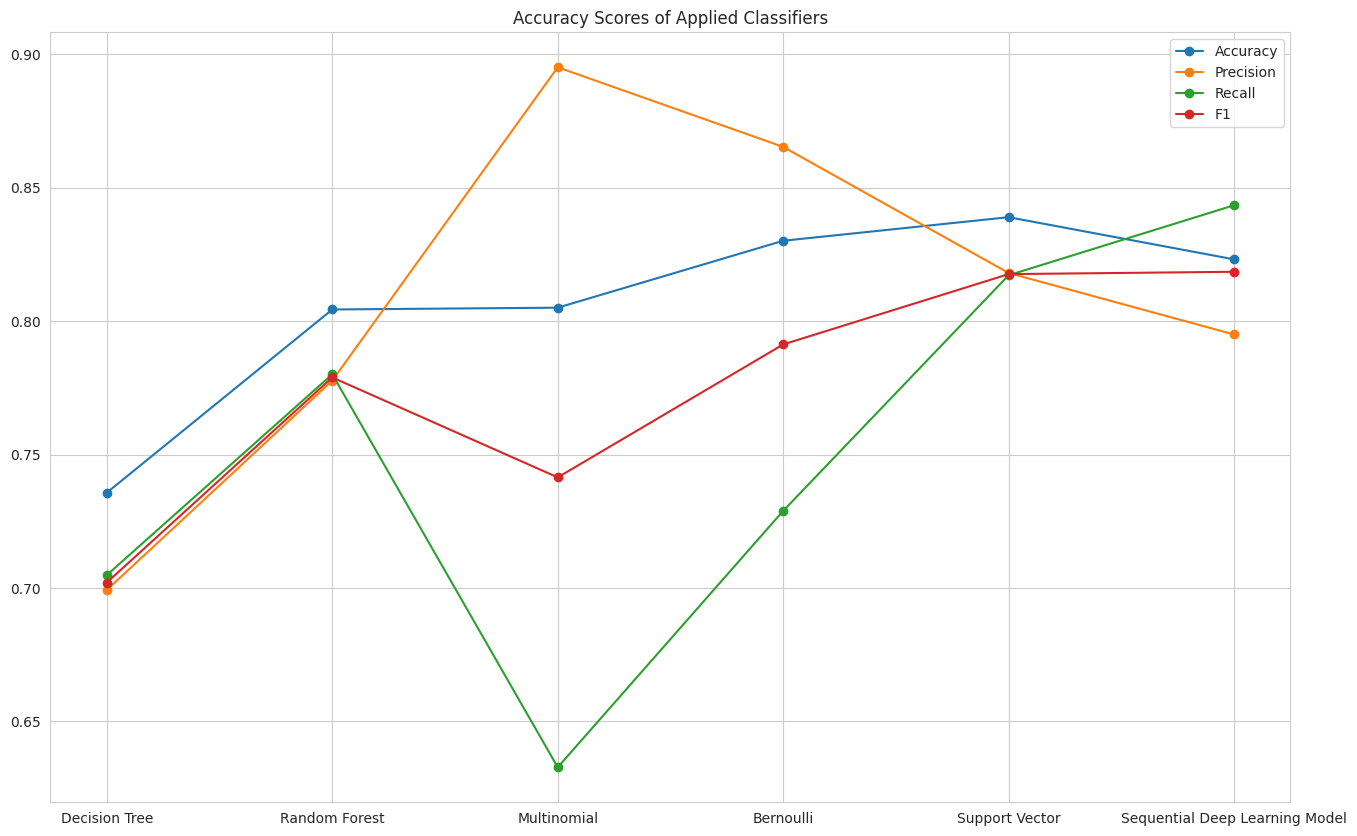

In [91]:
plt.figure(figsize=(16,10))
#plot 1:
x = np.array(['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model'])
y = np.array([d_accuracy, r_accuracy, m_accuracy, b_accuracy, s_accuracy, accuracy])
plt.plot(x,y, marker = 'o', label='Accuracy')

#plot 2:
x = np.array(['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model'])
y = np.array([d_precision, r_precision, m_precision, b_precision, s_precision, precision])
plt.plot(x,y, marker = 'o', label='Precision')

#plot 3:
x = np.array(['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model'])
y = np.array([d_recall, r_recall, m_recall, b_recall, s_recall, recall])
plt.plot(x,y, marker = 'o', label='Recall')

#plot 4:
x = np.array(['Decision Tree', 'Random Forest', 'Multinomial', 'Bernoulli', 'Support Vector', 'Sequential Deep Learning Model'])
y = np.array([d_f1, r_f1, m_f1, b_f1, s_f1, f1])
plt.plot(x,y, marker = 'o', label='F1')

plt.title("Accuracy Scores of Applied Classifiers")
plt.legend()
plt.show()